The only difference of Method 2 in Method 1 is the corner detection part. Instead of corner detectors, I will use template matching to get the coordinates of the corners/edges of the line

## Part 1: Pre-processing the input image

Same as method 1. Will not discuss anymore

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def pre_pros(image, erode_iter,dilate_iter, kernel_gauss):
    kernel = np.ones((2,2), np.uint8)
    image = cv2.erode(image, kernel, iterations = erode_iter) 
    image = cv2.dilate(image, kernel, iterations= dilate_iter)
    image = cv2.GaussianBlur(image, kernel_gauss, 100)
    image = cv2.copyMakeBorder(image, 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    
    return image

#image = cv2.imread( 'test_3.png')
#image_x = pre_pros(image, 2,5,(3,3))
#corner_x = corner_detection(image_x)

## Part 2: Template matching

This is the new entry

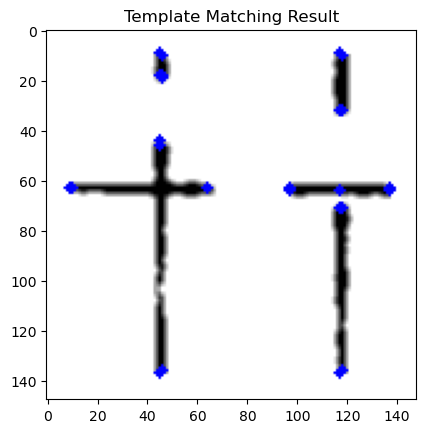

[(45, 18), (117, 32), (45, 137), (117, 137), (45, 9), (117, 9), (45, 44), (117, 71), (137, 64), (97, 64), (10, 63), (64, 63), (117, 64)]


In [60]:
def template_matching(image, mask_paths, threshold=0.8, distance_threshold=10, show_plot=True):
    # Convert to BGR for drawing red circles
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # List to store the centers
    all_centers = []

    for mask_path in mask_paths:
            # Load the mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            # Perform template matching
            result = cv2.matchTemplate(image, mask, cv2.TM_CCOEFF_NORMED)

            # Define a threshold to determine matches
            loc = np.where(result >= threshold)

            # List to store the centers for the current mask
            centers_list = []

            # Draw circles at the center of the matched areas in red and store the centers
            for pt in zip(*loc[::-1]):
                center = (pt[0] + int(mask.shape[1] / 2), pt[1] + int(mask.shape[0] / 2))
                centers_list.append(center)
                #cv2.circle(image_bgr, center, 5, (0, 0, 255), -1)

            # Filter closely located centers for the current mask
            filtered_centers = filter_close_centers(centers_list, distance_threshold)
            #print(filtered_centers)

            # Draw circles at the filtered centers in blue
            for center in filtered_centers:
                cv2.circle(image_bgr, center, 2, (255, 0, 0), -1)

            # Append the centers for the current mask to the overall list
            all_centers.extend(filtered_centers)

    # Display the result
    if show_plot:
        plt.imshow(cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB))
        plt.title('Template Matching Result')
        plt.show()
        
        
    final_centers = filter_close_centers(all_centers,5)

    return final_centers

def filter_close_centers(centers, distance_threshold):
    filtered_centers = []
    for center in centers:
        if all(np.linalg.norm(np.array(center) - np.array(existing_center)) > distance_threshold for existing_center in filtered_centers):
            filtered_centers.append(center)
    return filtered_centers

# Example usage
image = cv2.imread( 'test_3.png', cv2.IMREAD_GRAYSCALE)
image = pre_pros(image, 1,2,(3,3))

mask_paths = ['mask1.png', 'mask2.png', 'mask3.png', 'mask4.png',
              'mask5.png','mask6.png', 'mask7.png', 'mask8.png',
             'mask9.png','mask10.png', 'mask11.png', 'mask12.png',
             'mask13.png','mask14.png', 'mask15.png', 'mask16.png',
             'mask17.png','mask18.png', 'mask19.png', 'mask20.png']

corners = template_matching(image, mask_paths)
print(corners)


## Part 2: Connecting the corner coordinates
same as before

[((45, 130), (45, 139)), ((117, 116), (117, 139)), ((45, 11), (45, 104)), ((117, 11), (117, 77)), ((45, 139), (45, 130)), ((117, 139), (117, 116)), ((45, 104), (45, 11)), ((117, 77), (117, 11)), ((137, 84), (117, 84)), ((97, 84), (137, 84)), ((10, 85), (64, 85)), ((64, 85), (10, 85))]


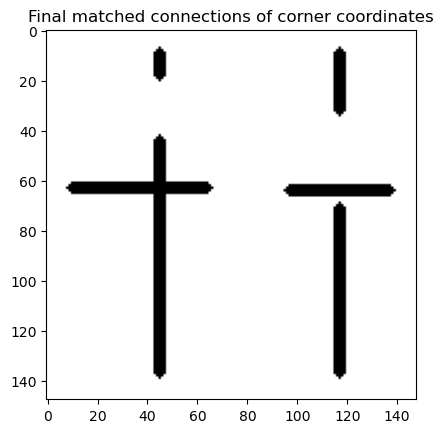

In [61]:
def connect_edges(image, corners, show_plot=True):
    thickness = 4 # thickness of the line
    height, width = image.shape[:2]
    final = np.ones((height, width, 3), dtype=np.uint8)* 255

    line_coor = []
    for i in range(len(corners)-1):
        criteria = []
        for j in range(0,len(corners)):
            if j == i:
                crit_score = 10000000
                criteria.append(crit_score)
            else:
                #-------------- uncomment this portion to see the masking
                #x = np.ones((height, width, 3), dtype=np.uint8)* 255
                #x = cv2.line(x, (corners[i][0], corners[i][1]),(corners[j][0], corners[j][1]), (0, 0, 0), thickness, cv2.LINE_8)
                #result = cv2.bitwise_and(image, image, mask = x) 
                #plt.imshow(x)
                #plt.show()
                #--------------
                
                mask = np.zeros((height, width), dtype=np.uint8)
                mask = cv2.line(mask, (corners[i][0], corners[i][1]), (corners[j][0], corners[j][1]), 255, 4, cv2.LINE_8)
                
                roi = image[mask > 0]

                sum_pix = np.sum(roi) #sum of pixel intensities in ROI
                num_pixels = np.sum(mask) # number of pixels in the ROI
                crit_score = sum_pix / num_pixels # average pixel value in the ROI
                #print(crit_score)
                criteria.append(crit_score)
                #print("score:", crit_score)
        max_index = np.argmin(criteria)
        #print("max_index = ",max_index)
        final = cv2.line(final, (corners[i][0], corners[i][1]), 
                     (corners[max_index][0], corners[max_index][1]), (0, 0, 0), thickness, cv2.LINE_8)
        coor = (corners[i][0], 148-corners[i][1]),(corners[max_index][0], 148-corners[max_index][1]) #minus 144 kasi pagbasa sa next step ay from bottom
        line_coor.append(coor)
    if show_plot:
        plt.imshow(final)
        plt.title("Final matched connections of corner coordinates")
    #print(line_coor)
    return line_coor



#USAGE:
image = cv2.imread( 'test_3.png', cv2.IMREAD_GRAYSCALE)
image = pre_pros(image, 1,2,(3,3))

mask_paths = ['mask1.png', 'mask2.png', 'mask3.png', 'mask4.png',
              'mask5.png','mask6.png', 'mask7.png', 'mask8.png',
             'mask9.png','mask10.png', 'mask11.png', 'mask12.png',
             'mask13.png','mask14.png', 'mask15.png', 'mask16.png',
             'mask17.png','mask18.png', 'mask19.png', 'mask20.png']

corners = template_matching(image, mask_paths, show_plot = False)
line_coor = connect_edges(image,corners)
print(line_coor)

## Part 3: Creating a vector given the matched corner coordinates of the lines
same as before

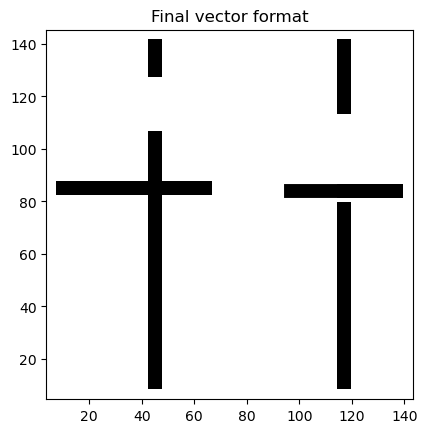

In [62]:
def create_vectorlines(lines, save_path, line_thickness, file_format='pdf', show_plot = True):
    fig, ax = plt.subplots()
    for line in lines:
        start_point, end_point = line
        ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], color='black', linewidth=line_thickness)
    # Set aspect ratio to be equal
    ax.set_aspect('equal')
    # Save the figure
    if file_format.lower() == 'pdf':
        plt.savefig(save_path, format='pdf', bbox_inches='tight')
    elif file_format.lower() == 'svg':
        plt.savefig(save_path, format='svg', bbox_inches='tight')
    else:
        print("Unsupported file format. Please choose 'pdf' or 'svg'. ONLYY")
    if show_plot:
        plt.title("Final vector format")
        plt.show()

create_vectorlines(line_coor, 'vector_test3b.pdf', line_thickness=10, file_format='pdf')

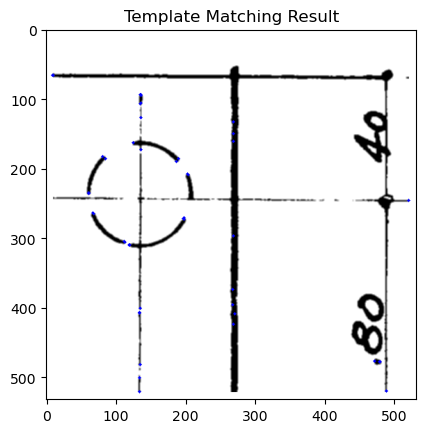

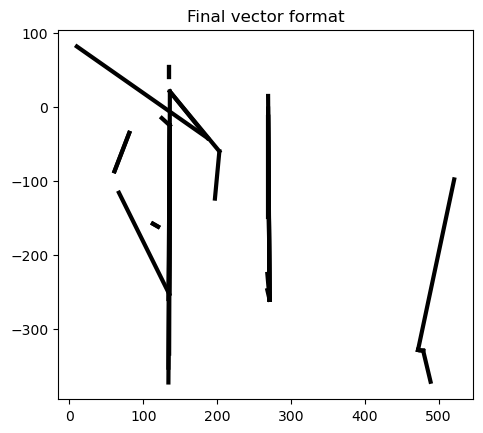

In [84]:
#To summarize:
image = cv2.imread( 'test_10.png', cv2.IMREAD_GRAYSCALE)
image = pre_pros(image, 1,1,(3,3))
plt.imshow(image, cmap = 'gray'), plt.title("original")
plt.show

mask_paths = ['mask1.png', 'mask2.png', 'mask3.png', 'mask4.png',
              'mask5.png','mask6.png', 'mask7.png', 'mask8.png',
             'mask9.png','mask10.png', 'mask11.png', 'mask12.png',
             'mask13.png','mask14.png', 'mask15.png', 'mask16.png',
             'mask17.png','mask18.png', 'mask19.png', 'mask20.png']

corners = template_matching(image, mask_paths, show_plot = True)
line_coor = connect_edges(image,corners, show_plot = False)
create_vectorlines(line_coor, 'vector_test10b.pdf', line_thickness=3, file_format='pdf')

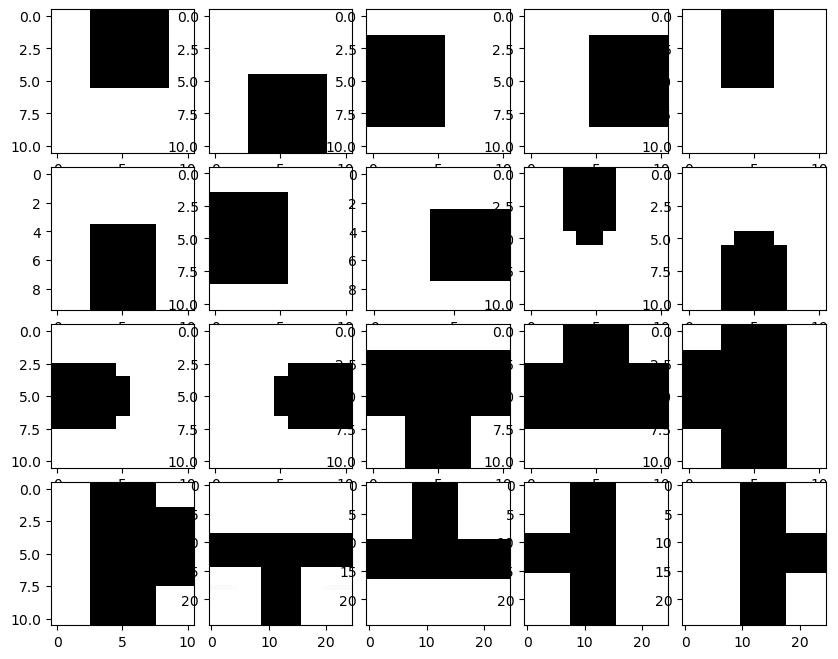

In [52]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.image import imread

# List of mask paths
mask_paths = ['mask1.png', 'mask2.png', 'mask3.png', 'mask4.png',
              'mask5.png', 'mask6.png', 'mask7.png', 'mask8.png',
              'mask9.png', 'mask10.png', 'mask11.png', 'mask12.png',
              'mask13.png', 'mask14.png', 'mask15.png', 'mask16.png',
              'mask17.png', 'mask18.png', 'mask19.png', 'mask20.png']

# Create a grid of subplots
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 5, wspace=0.1, hspace=0.1)

# Iterate over mask paths and plot images
for i, mask_path in enumerate(mask_paths):
    img = imread(mask_path)
    ax = plt.subplot(gs[i])
    ax.imshow(img, cmap='gray')  # Set cmap to 'gray'
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('auto')

plt.show()
